In [2]:
from bart import bart
import matplotlib.pyplot as plt
import numpy as np
import os
import twixtools


In [3]:
def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = ifftshift(ifftn(fftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def find_dat_files(folder):
    dat_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.dat'):
                dat_files.append(os.path.join(root, file))
    return dat_files

# read all image data from file
def read_image_data(filename):
    out = list()
    for mdb in twixtools.read_twix(filename)[-1]['mdb']:
        if mdb.is_image_scan():
            out.append(mdb.data)
    return np.asarray(out)  # 3D numpy array [acquisition_counter, n_channel, n_column]


# read image data from list of mdbs and sort into 3d k-space (+ coil dim.)
def import_kspace(mdb_list):
    image_mdbs = []
    for mdb in mdb_list:
        if mdb.is_image_scan():
            image_mdbs.append(mdb)

    n_line = 1 + max([mdb.cLin for mdb in image_mdbs])
    n_part = 1 + max([mdb.cPar for mdb in image_mdbs])
    n_channel, n_column = image_mdbs[0].data.shape

    out = np.zeros([n_part, n_line, n_channel, n_column], dtype=np.complex64)
    for mdb in image_mdbs:
        # '+=' takes care of averaging, but careful in case of other counters (e.g. echoes)
        out[mdb.cPar, mdb.cLin] += mdb.data

    return out  # 4D numpy array [n_part, n_line, n_channel, n_column]

In [4]:
!ls "/home/orel/Downloads/kspace/"

epi_se.seq
meas_MID00146_FID04783_Anatomy_for_us_t2_space_sag_cs4_iso.dat
meas_MID00148_FID04785_t1_se_sag.dat
meas_MID00149_FID04786_AdjCoilSens.dat
meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat
meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat
meas_MID00152_FID04789_AdjDico.dat
meas_MID00153_FID04790_AdjFre.dat
meas_MID00154_FID04791_AdjTra1D.dat
meas_MID00155_FID04792_AdjTra2D.dat
meas_MID00156_FID04793_AdjDico.dat
meas_MID00157_FID04794_AdjCoilSens.dat
meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat
meas_MID00167_FID04804_AdjFre.dat
meas_MID00169_FID04806_pulseq.dat


# READING ALL FILES 

In [5]:

ksp_dir = "/home/orel/Downloads/kspace/"
ksp_files = find_dat_files(ksp_dir)
ksp_files

['/home/orel/Downloads/kspace/meas_MID00155_FID04792_AdjTra2D.dat',
 '/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat',
 '/home/orel/Downloads/kspace/meas_MID00157_FID04794_AdjCoilSens.dat',
 '/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat',
 '/home/orel/Downloads/kspace/meas_MID00156_FID04793_AdjDico.dat',
 '/home/orel/Downloads/kspace/meas_MID00154_FID04791_AdjTra1D.dat',
 '/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat',
 '/home/orel/Downloads/kspace/meas_MID00146_FID04783_Anatomy_for_us_t2_space_sag_cs4_iso.dat',
 '/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat',
 '/home/orel/Downloads/kspace/meas_MID00153_FID04790_AdjFre.dat',
 '/home/orel/Downloads/kspace/meas_MID00149_FID04786_AdjCoilSens.dat',
 '/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat',
 '/home/orel/Downloads/kspace/meas_MID00152_FID04789_AdjDico.dat',
 '/home/orel/Downloads/kspace/meas

# Filter files that are Adj files

In [6]:
ksp_files = [f for f in ksp_files if "Adj" not in f and "Anatomy" not in f]
ksp_files

['/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat',
 '/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat',
 '/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat',
 '/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat',
 '/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat']

In [7]:
for f in ksp_files:
    twix = twixtools.read_twix(f,  keep_syncdata_and_acqend=True)
    last_measurement = twix[-1]
    print(f"{f} ReadFoV - {last_measurement['hdr']['Config']['ReadFoV']}")
    print(f"{f} PhaseFoV - {last_measurement['hdr']['Config']['PhaseFoV']}")
    print(f"{f} PhaseResolution - {last_measurement['hdr']['Config']['PhaseResolution']}")
    print(f"{f} dPhaseFOV - {last_measurement['hdr']['Dicom']['dPhaseFOV']}")

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 127M/127M [00:00<00:00, 1.02GB/s]


Scan  1


100%|██████████| 871M/871M [00:00<00:00, 2.41GB/s]


/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat ReadFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat PhaseFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat PhaseResolution - 0.5
/home/orel/Downloads/kspace/meas_MID00151_FID04788_t1_se_sag_Phase_Resolusion_50%.dat dPhaseFOV - 220.0
         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 127M/127M [00:00<00:00, 964MB/s] 


Scan  1


100%|██████████| 383M/383M [00:00<00:00, 3.53GB/s]


/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat ReadFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat PhaseFoV - 48.125
/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat PhaseResolution - 1.0
/home/orel/Downloads/kspace/meas_MID00159_FID04796_t1_se_sag_Phase_fov_21_9%.dat dPhaseFOV - 48.125
         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 96.8M/96.8M [00:00<00:00, 896MB/s]


Scan  1


100%|██████████| 1.47M/1.47M [00:00<00:00, 589MB/s]


/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat ReadFoV - 256.0
/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat PhaseFoV - 256.0
/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat PhaseResolution - 1.0
/home/orel/Downloads/kspace/meas_MID00169_FID04806_pulseq.dat dPhaseFOV - 256.0
         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 127M/127M [00:00<00:00, 1.20GB/s]


Scan  1


100%|██████████| 1.70G/1.70G [00:00<00:00, 2.47GB/s]


/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat ReadFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat PhaseFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat PhaseResolution - 1.0
/home/orel/Downloads/kspace/meas_MID00148_FID04785_t1_se_sag.dat dPhaseFOV - 220.0
         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 114M/114M [00:00<00:00, 1.80GB/s]


Scan  1


100%|██████████| 781M/781M [00:00<00:00, 2.53GB/s]

/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat ReadFoV - 220.0
/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat PhaseFoV - 110.0
/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat PhaseResolution - 1.0
/home/orel/Downloads/kspace/meas_MID00150_FID04787_t1_se_sag_fov_phase_50%.dat dPhaseFOV - 110.0


# Choose single file from options above

In [8]:
twix = twixtools.read_twix(ksp_files[3],  keep_syncdata_and_acqend=True)

# Access measurement data
last_measurement = twix[-1]
measurement_data_blocks = last_measurement['mdb']
for k,v in last_measurement.items():
    print(k)

for k in last_measurement['hdr']:
    print(k)
for k in last_measurement['raidfile_hdr']:
    print(k)
print(last_measurement['geometry'])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 127M/127M [00:00<00:00, 1.95GB/s]


Scan  1


100%|██████████| 1.70G/1.70G [00:00<00:00, 2.42GB/s]

mdb
hdr
hdr_str
raidfile_hdr
geometry
pmu
Config
Config_raw
Dicom
Dicom_raw
Meas
Meas_raw
MeasYaps
MeasYaps_raw
Phoenix
Phoenix_raw
Protocol
Protocol_raw
Spice
Spice_raw
148
4785
133999616
1827591968
b'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
b't1_se_sag'
Geometry:
  inplane_rot: 0
  normal: [0.995933, -0.089948, -0.005106]
  offset: [-84.2509116603, 21.4344151626, 3.43813392236]
  patient_position: HFS
  rotmatrix: [[-0.005106, -0.089948, -0.9959333735451039], [-0.00023010516284865276, 0.9959464357250469, -0.089948], [0.9999869378200571, -0.00023010516284865276, -0.005106]]
  voxelsize: [0.859375, 0.7801418439716312, 4.0]


# Reconstruct the image from raw-data file

In [9]:
twix = twixtools.read_twix(ksp_files[3],  keep_syncdata_and_acqend=True)
# map the twix data to twix_array objects
mapped = twixtools.map_twix(twix)
im_data = mapped[-1]['image']

# make sure that we later squeeze the right dimensions:
print("Dimensions: "  + str(im_data.non_singleton_dims))
line_index = im_data.non_singleton_dims.index("Lin")
col_index = im_data.non_singleton_dims.index("Col")
coil_index = im_data.non_singleton_dims.index("Cha")

# the twix_array object makes it easy to remove the 2x oversampling in read direction
im_data.flags['remove_os'] = True

# read the data (array-slicing is also supported)

print("data dimensions before squeeze: "  + str(im_data.shape))
data = im_data[:].squeeze()
print("data dimensions after squeeze: "  + str(data.shape))

image = ifftnd(data, [line_index, col_index])
image = rms_comb(image, axis=coil_index)


print("data shape - " + str(data.shape))
print("image shape - " + str(image.shape))

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 127M/127M [00:00<00:00, 1.84GB/s]


Scan  1


100%|██████████| 1.70G/1.70G [00:00<00:00, 2.55GB/s]


Dimensions: ['Sli', 'Lin', 'Cha', 'Col']
data dimensions before squeeze: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 27, 1, 282, 58, 256)
data dimensions after squeeze: (27, 282, 58, 256)
data shape - (27, 282, 58, 256)
image shape - (27, 282, 256)


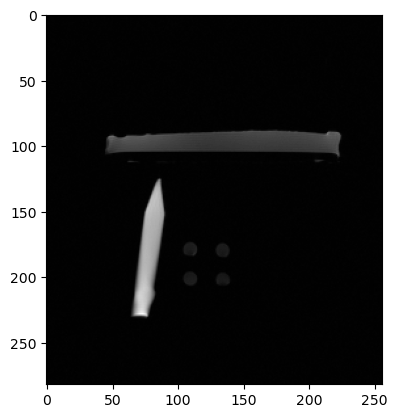

In [12]:
assert image.ndim == 3, "Image should be a 3D array with shape (slices, x, y)"

plt.figure()
plt.imshow(abs(image[20]), cmap="gray")
